# Bigraph Schema

This tutorial explores the bigraph schema library. Bigraph schema enables different simulators, models, and data to communicate with each other through standardized type definitions and wiring diagrams. By providing a robust type system and serializable data format, this makes composite simulators shareable, extendable, and easily distributed across various computer architectures.

This notebook uses the [bigraph-schema](https://pypi.org/project/bigraph-schema/) library for validation and processing of the schema, and the [bigraph-viz](https://pypi.org/project/bigraph-viz/) library for plotting library for visualizing the resulting simulation configuration.

This notebook is focused on type definition and access. For an introduction on Bigraphs and Process Bigraphs see [this notebook](https://vivarium-collective.github.io/process-bigraph/notebooks/process-bigraphs.html)

### Installation
To start, let's install the necessary libraries and display their versions:

In [1]:
# !pip install bigraph-schema
# !pip install bigraph-viz
!pip freeze | grep bigraph

-e git+https://github.com/vivarium-collective/bigraph-schema.git@3d378723574a5f8d8ea8e5b14d506d73bb80f5dd#egg=bigraph_schema
bigraph-viz==0.0.29


### Imports


In [2]:
from bigraph_schema import TypeSystem
from bigraph_viz import plot_bigraph, pf, pp
from bigraph_viz.dict_utils import schema_keys

## Type System
A type system comprises a set of rules and constraints that govern the organization, interaction, and manipulation of bigraph nodes, facilitating efficient and error-free compositional modeling by guaranteeing compatibility and seamless communication between various components within a simulation.

The main class for working with bigraph_schema is `SchemaTypes`, which handles the different type schemas and provides methods for their manipulation. We will use `SchemaTypes.validate_schema` to check our schemas, `SchemaTypes.access` to fill in missing details to prepare the schema for simulation, and `SchemaTypes.type_registry` to access different schemas and register new ones. 

*Schemas* serve as a formalized framework for defining and organizing types, providing explicit specifications for data representation, validation, and transformation. In a schema, types are characterized by specific `schema_keys` associated with type definitions, encompassing default values, serialization/deserialization methods, and additional metadata. The `schema_keys` encompass the following attributes. We will see specific instances of these below.

<span style="color:red">
TODO: how do we register new types, serializers, deserializers, etc?
</span>


In [3]:
types = TypeSystem()

In [30]:
# from bigraph_schema.registry import type_schema_keys
# type_schema_keys

## Type Registry
A type registry is used to store and manage schema definitions related to various simulation modules, streamlining the process of accessing, extending, and reusing type information across different components. 

The names of types available in the given registry can be printed:

In [5]:
types.type_registry.list()

['',
 'time^2/length',
 '/time',
 'length/time^2',
 'printing_unit/length',
 'length^3/time',
 'length^2/time^2',
 'any',
 'current*length^2*time',
 'length^3/mass*time^2',
 'mass',
 'length^2*mass/temperature*time^2',
 'int',
 'mass/temperature^4*time^3',
 '/substance',
 'luminosity/length^2',
 'length^2*mass/current*time^3',
 'length^2*mass/time',
 'mass/length*time^2',
 'length^3',
 'length*mass/current*time^3',
 'length^1_5*mass^0_5/time',
 'dict',
 'luminosity',
 'length*time/mass',
 'length*mass/time^2',
 'tree',
 'string',
 'current*time^2/length^2*mass',
 'current',
 'substance/length^3',
 'length^2*mass/time^3',
 'length^4*mass/time^3',
 'mass/time^3',
 'length^0_5*mass^0_5/time',
 'current*time',
 'mass^0_5/length^0_5*time',
 'current*time/mass',
 'length^1_5*mass^0_5/time^2',
 'mass/length^3',
 '/printing_unit',
 'maybe',
 'mass/length*time',
 'time',
 'length/time',
 'array',
 'list',
 'float',
 'current^2*time^4/length^2*mass',
 'length^2*mass/substance*temperature*time^2'

### Accessing a type
Type schemas can be accessed from the registry by their name. Here the `float` types shows that it uses an `accumulate` apply method, a `to_string` serialize method, that its default value is `0.0`, and that it inherits from (its super is) the `number` type.

In [27]:
float_schema = types.type_registry.access('float')
float_schema

{'_type': 'float',
 '_apply': 'accumulate',
 '_serialize': 'to_string',
 '_description': '64-bit floating point precision number',
 '_default': '0.0',
 '_deserialize': 'float',
 '_divide': 'divide_float',
 '_super': ['number']}

### Accessing schema methods
The `apply`, `serialize`, `deserialize`, `divide` methods of a type are accessed by the type system through their respective registries.

In [36]:
# here showing the method specified by the `float` type
apply_method = types.apply_registry.access(float_schema['_apply'])
serialize_method = types.serialize_registry.access(float_schema['_serialize'])
deserialize_method = types.deserialize_registry.access(float_schema['_deserialize'])
divide_method = types.divide_registry.access(float_schema['_divide'])
default_value = float_schema['_default']

print(f'default: {default_value}')
# print(f'default: {serialize_method(default_value)}')
print(f'after apply: {apply_method(default_value, 1.0)}')

default: 0.0


TypeError: accumulate() missing 2 required positional arguments: 'bindings' and 'types'

In [34]:
help(serialize_method)  # TODO -- bindings, types should be optional

Help on function to_string in module bigraph_schema.schema:

to_string(value, bindings, types)



In [37]:
help(apply_method)  # TODO -- bindings, types should be optional

Help on function accumulate in module bigraph_schema.schema:

accumulate(current, update, bindings, types)



### Use access to expand a composite type

Nested types have types within types. Here showing an `edge` type, which has wires that have their own types.

In [7]:
pp(types.type_registry.access('edge'))

{ '_apply': 'apply_edge',
  '_default': '{"wires": {}}',
  '_description': 'hyperedges in the bigraph, with ports as a type parameter',
  '_deserialize': 'deserialize_edge',
  '_divide': 'divide_edge',
  '_serialize': 'serialize_edge',
  '_type': 'edge',
  '_type_parameters': ['ports'],
  'wires': { '_apply': 'apply_tree',
             '_bindings': {'leaf': ['list', ['string']]},
             '_default': '{}',
             '_description': 'mapping from str to some type (or nested dicts)',
             '_deserialize': 'deserialize_tree',
             '_divide': 'divide_tree',
             '_leaf': { '_apply': 'concatenate',
                        '_bindings': {'element': 'string'},
                        '_default': '[]',
                        '_description': 'general list type (or sublists)',
                        '_deserialize': 'evaluate',
                        '_divide': 'divide_list',
                        '_element': { '_apply': 'replace',
                               

### Register a new type schema
You can add new types to the type registry using  `type_registry.register(type_name:str, type_schema:dict)`:

In [79]:
foursquare_schema = {
     # '_type': 'foursquare',
     '00': 'union[bool,foursquare]',
     '01': 'union[bool,foursquare]',
     '10': 'union[bool,foursquare]',
     '11': 'union[bool,foursquare]',
     '_default': {'00': False, '01': False, '10': False, '11': False},
     '_description': '',
}
types.type_registry.register(
    'foursquare', foursquare_schema)

type did not parse: union[bool,foursquare]


Traceback (most recent call last):
  File "/Users/eranagmon/code/bigraph-schema/bigraph_schema/registry.py", line 332, in access
    except Exception:
  File "/Users/eranagmon/code/bigraph-schema/bigraph_schema/registry.py", line 317, in access
    found['_bindings'] = dict(zip(
AttributeError: 'NoneType' object has no attribute 'copy'


Exception: trying to register a new type (foursquare), but it depends on a type (00) which is not in the registry

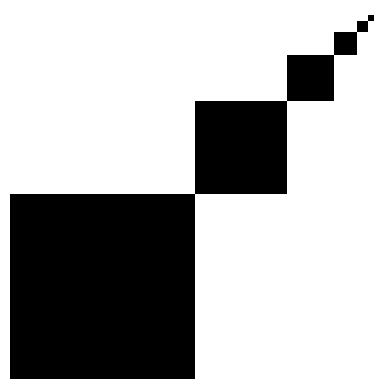

In [85]:
import os
import matplotlib.pyplot as plt
import numpy as np

def render(data, arr, x, y, size):
    if isinstance(data, dict):
        half_size = size // 2
        if '00' in data:
            render(data['00'], arr, x, y + half_size, half_size)
        if '01' in data:
            render(data['01'], arr, x + half_size, y + half_size, half_size)
        if '10' in data:
            render(data['10'], arr, x, y, half_size)
        if '11' in data:
            render(data['11'], arr, x + half_size, y, half_size)
    else:
        arr[y:y+size, x:x+size] = 0 if data else 1  # Change to '0 if data else 1' to make True values black

def find_depth(data):
    if isinstance(data, dict):
        return 1 + max(find_depth(data[key]) for key in data)
    return 0

def plot_foursquare(data, out_dir='out', filename=None):
    depth = find_depth(data)
    size = 2 ** depth
    arr = np.ones((size, size))
    render(data, arr, 0, 0, size)
    plt.imshow(arr, cmap='gray', interpolation='nearest')
    plt.axis('off')
    if filename:
        os.makedirs(out_dir, exist_ok=True)
        fig_path = os.path.join(out_dir, filename)
        plt.savefig(fig_path, format='png', dpi=300)
    plt.show()

# TODO: get this to register as a type
example = {
    '00': True, 
    '11': {
        '00': True, 
        '11': {
            '00': True, 
            '11': {
                '00': True, 
                '11': {
                    '00': True, 
                    '11': {
                        '00': True, 
                    },
                },
            },
        },
    },
}

plot_foursquare(example, filename="example.png")

## Instance
An instances is the particular set of values that populate a bigraph structure, adhering to a given schema. An instance encapsulates the current conditions and predicts future evolution based on the governing equations or rules. As the system evolves over time, the state transitions through various bigraphical configurations.

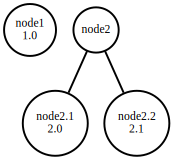

In [9]:
bigraph_state = {
    'node1': 1.0,
    'node2': {
        'node2.1': 2.0,
        'node2.2': 2.1
    }
}
plot_bigraph(bigraph_state, show_values=True)

### Fill state

One of the key advantages of a type system is its ability to improve automation in compositional modeling. The `fill` function exemplifies this by automatically populating missing schema elements. Given a schema and an incomplete instance, the fill function intelligently identifies and fills the missing schema components, ensuring that the instance is compliant with the schema definition.

In [10]:
dual_edge_schema = {
    'edge1': {
        '_type': 'edge',
        '_ports': {
            'port1': 'float',
            'port2': 'int',
        },
    },
    'edge2': {
        '_type': 'edge',
        '_ports': {
            'port1': 'float',
            'port2': 'int',
        },
    },
}    

types.type_registry.register('dual_edge', dual_edge_schema, force=True)

schema = {
    'store1': 'dual_edge',
    'edge3': {
        '_type': 'edge',
        '_ports': {
            'port1': 'dual_edge'
        }
    }
}

instance = {
    'store1': {
        'edge1': {
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        'edge2': {
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        }
    },
    'edge3': {
        'wires': {
            'port1': 'store1',
        }
    },
}
filled_instance = types.fill(schema, instance)
filled_schema = types.type_registry.access(schema)

In [11]:
print(f'schema:\n {pf(schema)}\n')
print(f'instance:\n {pf(instance)}\n')
# print(f'filled schema:\n {pf(filled_schema)}\n')
print(f'filled instance:\n {pf(filled_instance)}\n')

schema:
 { 'edge3': {'_ports': {'port1': 'dual_edge'}, '_type': 'edge'},
  'store1': 'dual_edge'}

instance:
 { 'edge3': {'wires': {'port1': 'store1'}},
  'store1': { 'edge1': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'edge2': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}}}}

filled instance:
 { 'edge3': {'wires': {'port1': 'store1'}},
  'store1': { 'edge1': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'edge2': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'store1.1': 0.0,
              'store1.2': 0}}



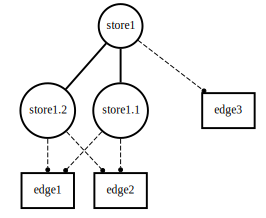

In [12]:
plot_bigraph(filled_instance, remove_process_place_edges=True, port_labels=False)

## Update

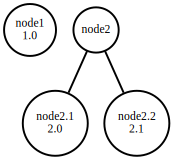

In [13]:
place_schema = {
    '_type': 'tree[float]',
}

place_state1 = {
    'node1': 1.0,
    'node2': {
        'node2.1': 2.0,
        'node2.2': 2.1
    }
}
plot_bigraph(place_state1, show_values=True)

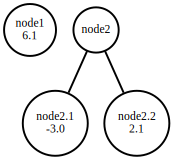

In [14]:
update = {
    'node1': 5.1,
    'node2': {
        'node2.1': -5.0,
        # 'node2.2': -2.0
    }
}

place_state2 = types.apply(
    place_schema,
    place_state1,
    update
)
plot_bigraph(place_state2, show_values=True)

In [15]:
# update = {
#     '_remove': ['node1'],
#     'node2': {
#         '_remove': ['node2.2'],
#         'node2.3': 0.5,
#         'node2.4': {'node2.2.1': -2.0}
#     }
# }
update = {
    '_remove': [
        ['node1'], 
        ['node2', 'node2.2'],
    ],
}

place_state3 = types.apply(
    place_schema,
    place_state2,
    update
)
plot_bigraph(place_state2, show_values=True)

TypeError: unhashable type: 'list'

## View/Project through wires

## Query

Find a schema within a composite. For example find a mitochondria within a cell

## Adapters

Show how adapters can automatically compose into a schema to provide translation between types.